# **Blackjack DQN**

**Rules:**
- Dealer gets one face down card, player gets one face up card
- Dealer gets one face up card, player gets one face up card
- Player hits, stays, or doubles (1 more hit)
- Repeat until stay or bust
- Play out dealers hand (hit if below 17)
- Winner is higher non-bust hand total
- Bet size is 2, payout is 2 for win, 3 for blackjack (payouts doubled if double was called)
- Assuming only one deck is used, shuffled after every game
- Aces are only 11s
- Ties are always 0 profit, even if blackjack was made with different numbers of cards

**Design:**
- Double DQN with policy network and target network
- input to network is batch of 104-length state tensors:
    - 52 values for visible player cards (0s or 1s, organized by number and within number organized by suit, clubs first then diamonds then hearts then spades)
    - 52 values for visible dealer card (same 0/1 encoding)
    - NOT keeping track of remaining cards in deck (for simplicity)
- output of network is batch of 3-length tensors w/ distribution of q-values over action space (estimated total value of taking each action)
    - 3 values for hit, stay, double
- standard epsilon-greedy exploration
- standard experience replay


In [1]:
# DQN structure

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(104, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, 3)
    
    def forward(self, x):  # x is a batch of state tensors, if only one state is input it must be 2-dimensional
        x.float()
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


In [2]:
# Experience Replay memory class
from collections import namedtuple, deque
import random

Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state'])

class ReplayMemory():

    def __init__(self, cap):
        self.memory = deque([], maxlen=cap)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [3]:
# model optimizer from experience replay
NUM_GAMES = 100000  # total number of games to train DQN on
BATCH_SIZE = 100
GAMMA = 0.99  # discount of future expected value
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 20000  # number of randomly selected actions until epsilon decay has 1/e left (37%) 
TAU = 0.005  # portion of weights transferred to target net every update
LR = 1e-4

policy_net = DQN().to("cuda")
target_net = DQN().to("cuda")
target_net.load_state_dict(policy_net.state_dict())

memory = ReplayMemory(10000)
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

def optimize_dqn():
    # Only optimize when we have enough states in memory
    if len(memory) < BATCH_SIZE:
        return
    
    batch = memory.sample(BATCH_SIZE)  # List of transitions
    batch = Transition(*zip(*batch))  # Transition of lists

    next_state_mask = torch.tensor([ns is not None for ns in batch.next_state], device="cuda", dtype=torch.bool)
    

    sa_values = torch.gather(policy_net(torch.cat(batch.state)), dim=1, index=torch.cat(batch.action))
    exp_sa_values = torch.cat(batch.reward)

    existing_next_states = [s for s in batch.next_state if s is not None]

    if len(existing_next_states) > 0:       

        next_states = torch.cat(existing_next_states)

        with torch.no_grad():
            next_state_values = target_net(next_states).max(1).values.unsqueeze(1)

        exp_sa_values[next_state_mask] += GAMMA * next_state_values

    loss_func = nn.MSELoss()
    loss = loss_func(sa_values, exp_sa_values)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [4]:
# epsilon greedy action selection
import math

actions_taken = 0

def select_action(state):
    global actions_taken
    x = random.random()
    threshold = math.exp(-actions_taken/EPS_DECAY) * (EPS_START - EPS_END) + EPS_END
    actions_taken += 1
    if x <= threshold:  # Pick random action
        return torch.tensor([[random.randint(0, 2)]], device="cuda")
    else:  # Pick action with highest predicted Q-value
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)


In [5]:
# game state management

deck = []
p_up, d_up = set(), set()
d_hidden = -1
p_sum, d_sum = 0, 0


def get_state():
    p_tensor = torch.tensor([1 if card in p_up else 0 for card in range(52)], device="cuda", dtype=torch.float32)
    d_tensor = torch.tensor([1 if card in d_up else 0 for card in range(52)], device="cuda", dtype=torch.float32)
    return torch.cat((p_tensor, d_tensor)).unsqueeze(0)


def card_value(idx):  # 2s, then 3s, then..., then Ks, then As
    order = idx // 4 + 2
    if 11 <= order <= 13:  # Jacks, Queens, Kings
        return 10
    elif order == 14:  # Aces
        return 11
    else:
        return order


# Note: if player initially dealt two aces, even though they are busted they can still act, this won't affect result as they will still lose hand
def reset_game(override_deck=None):
    global deck, p_up, d_up, d_hidden, p_sum, d_sum
    p_up, d_up = set(), set()
    d_hidden = -1
    p_sum, d_sum = 0, 0

    if override_deck:
        deck = override_deck
    else:
        deck = [i for i in range(52)]
        random.shuffle(deck)

    # Set up game with top 4 cards    
    a, b, c, d = deck.pop(0), deck.pop(0), deck.pop(0), deck.pop(0)

    p_up.add(a)
    d_hidden = b
    p_up.add(c)
    d_up.add(d)

    p_sum += card_value(a) + card_value(c)
    d_sum += card_value(b) + card_value(d)

    return get_state()


def print_state():
    print(f"Dealer:   Facedown ({card_value(d_hidden)})   Up ({[card_value(c) for c in d_up]})")
    print(f"Player:   Up ({[card_value(c) for c in p_up]})")


def act(action):  # 0 = hit, 1 = stay, 2 = double
    global deck, p_up, d_up, d_hidden, p_sum, d_sum
    end, double = False, False
    reward = 0

    if action == 0:  # hit
        new = deck.pop(0)
        p_up.add(new)
        p_sum += card_value(new)
        if p_sum >= 21:
            end = True
    elif action == 1:  # stay
        end = True
    else:  # double
        new = deck.pop(0)
        p_up.add(new)
        p_sum += card_value(new)
        end = True
        double = True

    if end: 
        if p_sum > 21:  # bust
            base = -2
        else:
            while d_sum < 17:  # finish dealer's hand
                new = deck.pop(0)
                d_up.add(new)
                d_sum += card_value(new)
            if d_sum == p_sum:  # tie, no busts
                base = 0
            elif p_sum == 21:  # player blackjack, no tie
                base = 3
            elif d_sum > 21:  # only dealer busts
                base = 2
            elif p_sum < d_sum:  # dealer wins, no busts
                base = -2
            elif p_sum > d_sum:  # player wins, no busts
                base = 2
        
        reward = 2*base if double else base

    new_state = get_state() if not end else None
    return new_state, reward, end

In [6]:
# from matplotlib import pyplot as plt
# from IPython import display

# # episode iteration
# NUM_GAMES = 100000
# WIN_RATE_LENGTH = 1000
# win_history = []
# win_sum = 0
# win_rates = []
# profit_history = []
# profit_sum = 0
# avg_profits = []

# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# legend = None

# for g in range(1, NUM_GAMES+1):
#     # in each episode:
#     # - initialize random game state
#     # - repeat: take action, push result to memory, optimize model, soft update target network
#     # - until terminal game state
#     # - record win/loss

#     state = reset_game()

#     for i in range(100):
#         if i == 99:
#             print("didn't break loop")
#             break

#         action = select_action(state)
#         next_state, reward, end = act(action)
#         reward = torch.tensor([[reward]], device="cuda", dtype=torch.float)
#         memory.push(state, action, reward, next_state)
#         state = next_state

#         optimize_dqn()

#         target_params = target_net.state_dict()
#         policy_params = policy_net.state_dict()

#         for k in policy_params:
#             target_params[k] = (1-TAU) * target_params[k] + TAU * policy_params[k]
        
#         target_net.load_state_dict(target_params)

#         if end:
#             if reward.item() > 0:
#                 result = 1
#             else:
#                 result = 0
            
#             win_history.append(result)
#             win_sum += result
#             if len(win_history) > WIN_RATE_LENGTH:
#                 oldest = win_history.pop(0)
#                 win_sum -= oldest
#             win_rates.append(win_sum/min(g, WIN_RATE_LENGTH))

#             profit_history.append(reward.item())
#             profit_sum += reward.item()
#             if len(profit_history) > WIN_RATE_LENGTH:
#                 oldest = profit_history.pop(0)
#                 profit_sum -= oldest
#             avg_profits.append(profit_sum/min(g, WIN_RATE_LENGTH))

#             if g % 20 == 0:
#                 # clear old axes/legend
#                 ax1.cla()
#                 ax2.cla()
#                 if legend:
#                     legend.remove()

#                 # set axis labels
#                 ax1.set_xlabel('# of Games Played')
#                 ax1.set_ylabel('Win %')
#                 ax2.set_ylabel('Avg. Profit')
#                 ax2.yaxis.set_label_position("right")

#                 # plot updated data w/ legend
#                 ax1.plot(win_rates[20:], color="r", label='Win Rate of Past 1k Games')
#                 ax2.plot(avg_profits[20:], color="b", label='Avg Profit of Past 1k Games')
#                 legend = fig.legend()

#                 # redraw figure
#                 display.display(fig)
#                 display.clear_output(wait=True)
            
#             break

In [7]:
def rolling_average(arr, lookback):
    out = []
    
    for i in range(len(arr)-lookback):
        out.append(sum(arr[i:i+lookback])/lookback)
    
    return out

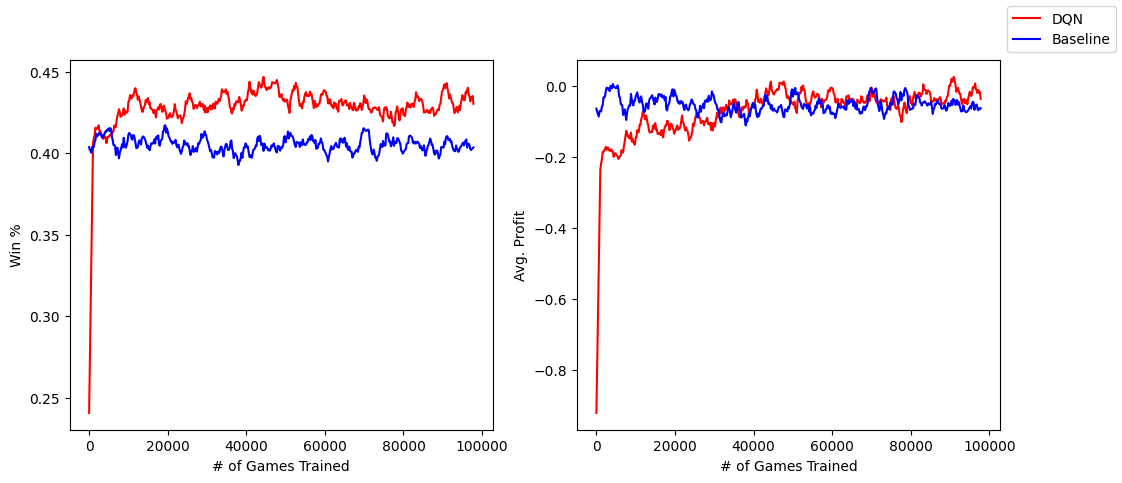

In [8]:
from matplotlib import pyplot as plt
from IPython import display

# episode iteration
TEST_BATCH_SIZE = 1000  # number of games used to test win rate of DQN at each stage of training
UPDATE_WIDTH = 200  # number of games in between testing win rate/profit and graphing it
SMOOTH_FACTOR = 10  # lookback for rolling average for graph
dqn_avg_profits, baseline_avg_profits = [], []
dqn_win_rates, baseline_win_rates = [], []

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
legend = None

for g in range(1, NUM_GAMES+1):
    # in each episode:
    # - initialize random game state
    # - repeat: take action, push result to memory, optimize model, soft update target network
    # - until terminal game state
    # - record win/loss

    state = reset_game()

    for i in range(100):
        if i == 99:
            print("didn't break loop")
            break

        action = select_action(state)
        next_state, reward, end = act(action)
        reward = torch.tensor([[reward]], device="cuda", dtype=torch.float)
        memory.push(state, action, reward, next_state)
        state = next_state

        optimize_dqn()

        target_params = target_net.state_dict()
        policy_params = policy_net.state_dict()

        for k in policy_params:
            target_params[k] = (1-TAU) * target_params[k] + TAU * policy_params[k]
        
        target_net.load_state_dict(target_params)

        if end:
            if reward.item() > 0:
                result = 1
            else:
                result = 0

            if g % UPDATE_WIDTH == 0:
                test_dqn_wins, test_baseline_wins = 0, 0
                test_dqn_profit, test_baseline_profit = 0, 0
                action_count = [0, 0, 0]
                action_values = []
                
                # test on 100 games
                for _ in range(TEST_BATCH_SIZE):

                    random_deck = [i for i in range(52)]
                    random.shuffle(random_deck)

                    # DQN
                    state = reset_game(random_deck)

                    for i in range(100):
                        if i == 99:
                            print("didn't break loop dqn")
                            break

                        with torch.no_grad():
                            values = policy_net(state)
                            action_values = values
                            action = values.max(1).indices.view(1, 1)
                        action_count[action] += 1
                        next_state, reward, end = act(action)
                        state = next_state

                        if end:
                            if reward > 0:
                                test_dqn_wins += 1
                            
                            test_dqn_profit += reward
                            break
                    
                    # Baseline
                    state = reset_game(random_deck)

                    for i in range(100):
                        if i == 99:
                            print("didn't break loop baseline")
                            break

                        action = 2 if p_sum == 10 or p_sum == 11 else 0
                        if p_sum >= 17:
                            action = 1

                        _, reward, end = act(action)

                        if end:
                            if reward > 0:
                                test_baseline_wins += 1
                            
                            test_baseline_profit += reward
                            break
                
                baseline_win_rates.append(test_baseline_wins/TEST_BATCH_SIZE)
                baseline_avg_profits.append(test_baseline_profit/TEST_BATCH_SIZE)
                dqn_win_rates.append(test_dqn_wins/TEST_BATCH_SIZE)
                dqn_avg_profits.append(test_dqn_profit/TEST_BATCH_SIZE)

                # clear old axes/legend
                ax1.cla()
                ax2.cla()
                if legend:
                    legend.remove()

                # set axis labels
                ax1.set_xlabel('# of Games Trained')
                ax1.set_ylabel('Win %')
                ax2.set_xlabel('# of Games Trained')
                ax2.set_ylabel('Avg. Profit')

                # plot updated data w/ legend
                ax1.plot([UPDATE_WIDTH*i for i in range(len(dqn_win_rates)-SMOOTH_FACTOR)], rolling_average(dqn_win_rates, SMOOTH_FACTOR), color="r", label='DQN')
                ax1.plot([UPDATE_WIDTH*i for i in range(len(dqn_win_rates)-SMOOTH_FACTOR)], rolling_average(baseline_win_rates, SMOOTH_FACTOR), color="b", label='Baseline')
                ax2.plot([UPDATE_WIDTH*i for i in range(len(dqn_win_rates)-SMOOTH_FACTOR)], rolling_average(dqn_avg_profits, SMOOTH_FACTOR), color="r")
                ax2.plot([UPDATE_WIDTH*i for i in range(len(dqn_win_rates)-SMOOTH_FACTOR)], rolling_average(baseline_avg_profits, SMOOTH_FACTOR), color="b")
                legend = fig.legend()

                # redraw figure
                display.display(fig)
                print(action_count, action_values)
                display.clear_output(wait=True)
            
            break

In [9]:
## Baseline strategy (double 10/11, hit <17, stay otherwise)
# baseline_win_history = []
# baseline_win_sum = 0
# baseline_win_rates = []
# baseline_profit_history = []
# baseline_profit_sum = 0
# baseline_avg_profits = []

# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# legend = None

# for g in range(1, NUM_GAMES+1):

#     state = reset_game()

#     for i in range(100):
#         if i == 99:
#             print("didn't break loop")
#             break

#         action = 2 if p_sum == 11 or p_sum == 10 else 0
#         if p_sum >= 17:
#             action = 1

#         _, reward, end = act(action)

#         if end:
#             if reward > 0:
#                 result = 1
#             else:
#                 result = 0
            
#             baseline_win_history.append(result)
#             baseline_win_sum += result
#             if len(baseline_win_history) > WIN_RATE_LENGTH:
#                 oldest = baseline_win_history.pop(0)
#                 baseline_win_sum -= oldest
#             baseline_win_rates.append(baseline_win_sum/min(g, WIN_RATE_LENGTH))

#             baseline_profit_history.append(reward)
#             baseline_profit_sum += reward
#             if len(baseline_profit_history) > WIN_RATE_LENGTH:
#                 oldest = baseline_profit_history.pop(0)
#                 baseline_profit_sum -= oldest
#             baseline_avg_profits.append(baseline_profit_sum/min(g, WIN_RATE_LENGTH))


#             if g % 20 == 0:
#                 # clear old axes/legend
#                 ax1.cla()
#                 ax2.cla()
#                 if legend:
#                     legend.remove()

#                 # set axis labels
#                 ax1.set_xlabel('# of Games Played')
#                 ax1.set_ylabel('Win %')
#                 ax2.set_ylabel('Avg. Profit')
#                 ax2.yaxis.set_label_position("right")

#                 # plot updated data w/ legend
#                 ax1.plot(baseline_win_rates[20:], color="r", label='Win Rate of Past 1k Games')
#                 ax2.plot(baseline_avg_profits[20:], color="b", label='Avg Profit of Past 1k Games')
#                 legend = fig.legend()

#                 # redraw figure
#                 display.display(fig)
#                 display.clear_output(wait=True)
#             break

In [10]:
# Test trained model against baseline for 5k games on the SAME INITIAL STATES

TEST_SIZE = 100000
dqn_profit, baseline_profit = 0, 0
dqn_wins, baseline_wins = 0, 0
action_count = [0, 0, 0]

for game in range(TEST_SIZE):

    if game % (TEST_SIZE // 10) == 0:
        print(f"Testing on game {game+1}")

    random_deck = [i for i in range(52)]
    random.shuffle(random_deck)

    ##################################
    #      Testing DQN strategy      #
    ##################################
    
    state = reset_game(random_deck)

    for i in range(100):
        if i == 99:
            print("didn't break loop dqn")
            break

        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
        action_count[action] += 1  # keep track of how many times the network chooses each action, for evaluation purposes
        next_state, reward, end = act(action)
        state = next_state

        if end:
            if reward > 0:
                dqn_wins += 1
            
            dqn_profit += reward
            break
    
    ##################################
    #   Testing baseline strategy    #
    ##################################

    state = reset_game(random_deck)

    for i in range(100):
        if i == 99:
            print("didn't break loop baseline")
            break

        action = 2 if p_sum == 10 or p_sum == 11 else 0
        if p_sum >= 17:
            action = 1

        _, reward, end = act(action)

        if end:
            if reward > 0:
                baseline_wins += 1
            
            baseline_profit += reward
            break

print("\nResults:")
print(f"DQN win rate: {dqn_wins/TEST_SIZE}")
print(f"Baseline win rate: {baseline_wins/TEST_SIZE}")
print(f"DQN avg profit: {dqn_profit/TEST_SIZE}")
print(f"Baseline avg profit: {baseline_profit/TEST_SIZE}")
print(f"Action choice: {action_count}")
        

Testing on game 1
Testing on game 10001
Testing on game 20001
Testing on game 30001
Testing on game 40001
Testing on game 50001
Testing on game 60001
Testing on game 70001
Testing on game 80001
Testing on game 90001

Results:
DQN win rate: 0.43074
Baseline win rate: 0.40245
DQN avg profit: -0.02513
Baseline avg profit: -0.06474
Action choice: [55688, 74119, 3244]


(baseline is the same in each test, just showing numbers each time to give an idea of the variance)

# **Using L1 Loss:**
## With 12000 training games:
### 3 layers:

16 neurons: DQN 41.8% win rate, -0.19 avg profit; Baseline 40.3% win rate, -0.06 avg profit

128 neurons: DQN 41.0% win rate, -0.14 avg profit; Baseline 40.5% win rate, -0.05 avg profit

### 4 layers:

16 neurons: DQN 41.1% win rate, -0.18 avg profit; Baseline 40.6% win rate, -0.05 avg profit

128 neurons: DQN 39.8% win rate, -0.21 avg profit; Baseline 40.7% win rate, -0.05 avg profit 

## With 100000 training games:

16 neurons, 3 layers: DQN 41.4% win rate, -0.08 avg profit; Baseline 40.6% win rate, -0.05 avg profit

16 neurons, 4 layers: DQN 41.9% win rate, -0.07 avg profit; Baseline 40.5% win rate, -0.06 avg profit

128 neurons, 4 layers: DQN 41.6% win rate, -0.09 avg profit; Baseline 40.7% win rate, -0.05 avg profit


# **Using MSE Loss:**
## With 100000 training games:

**(BEST MODEL) 16 neurons, 3 layers: DQN 43.1% win rate, -0.03 avg profit; Baseline 40.4% win rate, -0.06 avg profit**

128 neurons, 3 layers: DQN 42.5% win rate, -0.07 avg profit; Baseline 40.4% win rate, -0.06 avg profit

In [12]:
## example hands
actions = ["Hit", "Stay", "Double"]

for _ in range(10):

    state = reset_game()
    print_state()

    for i in range(100):
        if i == 99:
            print("didn't break loop dqn")
            break

        with torch.no_grad():
            vals = policy_net(state)
            print(f"Action values: {vals}")
            action = vals.max(1).indices.view(1, 1)
        
        print(f"Action: {actions[action]}")
        next_state, reward, end = act(action)
        print_state()
        state = next_state

        if end:
            print(f"Reward: {reward}\n")
            break


Dealer:   Facedown (5)   Up ([10])
Player:   Up ([8, 6])
Action values: tensor([[-0.4555, -1.8407, -1.6056]], device='cuda:0')
Action: Hit
Dealer:   Facedown (5)   Up ([10])
Player:   Up ([8, 6, 10])
Reward: -2

Dealer:   Facedown (7)   Up ([11])
Player:   Up ([10, 10])
Action values: tensor([[-2.5084,  0.4315, -4.0210]], device='cuda:0')
Action: Stay
Dealer:   Facedown (7)   Up ([11])
Player:   Up ([10, 10])
Reward: 2

Dealer:   Facedown (10)   Up ([6])
Player:   Up ([6, 8])
Action values: tensor([[-0.4347, -0.4978, -1.0816]], device='cuda:0')
Action: Hit
Dealer:   Facedown (10)   Up ([6])
Player:   Up ([6, 11, 8])
Reward: -2

Dealer:   Facedown (5)   Up ([4])
Player:   Up ([8, 10])
Action values: tensor([[-1.4068,  0.6703, -2.3616]], device='cuda:0')
Action: Stay
Dealer:   Facedown (5)   Up ([4, 10])
Player:   Up ([8, 10])
Reward: -2

Dealer:   Facedown (10)   Up ([10])
Player:   Up ([8, 10])
Action values: tensor([[-1.3119, -0.2911, -2.2795]], device='cuda:0')
Action: Stay
Dealer:  

# Observations:
- In general, simplicity in architecture (fewer neurons and fewer layers) led to better performance. Likely due to simplicity of game.

- L1 loss had notably worse performance. Action values were converging near -2/-2/-4, which is not an accurate reflection of future EV.
   - This makes sense: MSE loss optimization (derivative) is linear in terms of probability of different outcomes (+2/-2), which is what we want.

- With L1 loss, DQN could get a better win rate than baseline, but had worse average profit (which is what the DQN is optimizing for!) by a very small amount.
- DQN learned a decent strategy in <100 games, learned very slowly after that.
- The extra learning was still valuable; the 100k-game network performed noticeably better than the 12k-game network

## Examples of learned DQN strategy:

In [ ]:
# Staying on 13 with dealer 6. Probably because if dealer has a facedown 10 (modal outcome), they will have to draw again and will likely bust.
# Note that the action values for hitting/staying are very close.

# Dealer:   Facedown (3)   Up ([6])
# Player:   Up ([8, 5])
# Action values: tensor([[-0.5581, -0.5303, -1.3502]], device='cuda:0')
# Action: Stay
# Dealer:   Facedown (3)   Up ([6, 11])
# Player:   Up ([8, 5])
# Reward: -2


# Staying on 16 with dealer 6. Likely the same reason.

# Dealer:   Facedown (11)   Up ([6])
# Player:   Up ([5, 3])
# Action values: tensor([[-0.0452, -1.9108, -0.5354]], device='cuda:0')
# Action: Hit
# Dealer:   Facedown (11)   Up ([6])
# Player:   Up ([4, 5, 3])
# Action values: tensor([[-0.3722, -1.0776, -1.3623]], device='cuda:0')
# Action: Hit
# Dealer:   Facedown (11)   Up ([6])
# Player:   Up ([4, 4, 5, 3])
# Action values: tensor([[-0.8480,  0.4565, -2.2525]], device='cuda:0')
# Action: Stay
# Dealer:   Facedown (11)   Up ([6])
# Player:   Up ([4, 4, 5, 3])
# Reward: -2


# Staying on 16 with dealer 3. This one seems harder to justify.

# Dealer:   Facedown (11)   Up ([3])
# Player:   Up ([7, 9])
# Action values: tensor([[-0.7590, -0.2199, -1.6147]], device='cuda:0')
# Action: Stay
# Dealer:   Facedown (11)   Up ([9, 3])
# Player:   Up ([7, 9])
# Reward: 2


# Doubling on 11. This isn't different from the baseline, but shows that the DQN learned to incorporate the doubling strategy effectively.
# With L1 loss, it did not learn this strategy.

# Dealer:   Facedown (3)   Up ([10])
# Player:   Up ([4, 7])
# Action values: tensor([[ 0.1797, -2.6180,  0.4335]], device='cuda:0')
# Action: Double
# Dealer:   Facedown (3)   Up ([10, 9])
# Player:   Up ([4, 8, 7])
# Reward: 4